# What is torch.nn Really?

## MNIST data setup

We will use the classic Mnist dataset, which consits of black-and-white iamges of hand-drawn digits(between 0 and 9).

In [7]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'

PATH.mkdir(parents=True, exist_ok=True)

# URL = 'http://deeplearning.net/data/mnist/'
FILENAME = 'mnist.pkl.gz'
URL = 'https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'

if not (PATH / FILENAME).exists():
    content = requests.get(URL).content
    (PATH / FILENAME).open('wb').write(content)

In [8]:
import pickle
import gzip

with gzip.open((PATH/FILENAME).as_posix(), 'rb') as f:
    ret = pickle.load(f, encoding='latin-1')
    (x_train, y_train), (x_valid, y_valid), _ = ret

Each image is 28x28,and is being stored as a flattened row of length 748.

(50000, 784)


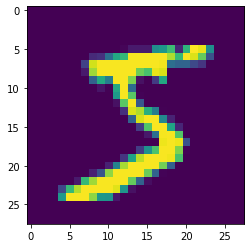

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28, 28)))
print(x_train.shape)

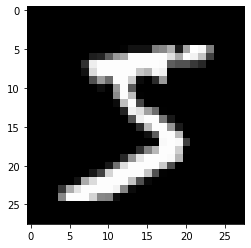

In [12]:
plt.imshow(x_train[0].reshape(28, -1), cmap='gray')

In [13]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor,
                                        (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Neural net from scratch(no torch.nn)

Let's first create a model using nothing but PyTorch tensor operations. 

PyTorch provides methods to create random or zero-filled tensors, which we will use to create our weights and bias for a simple linear model. These are just regular tensors, with one very special addition: we tell PyTroch that they require a gradient. This causes PyTorch to record all of the operations done on the tensor, so that it can calculate the gradient during back-propagation automatically.

For the weights, we set `requires_grad` after the initialization, since we don't want that step included in the gradient.

In [15]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

> We are initializing the weighs here with `Xavier initializaion`(by multiplying with $1/sqrt(n)$)

Thanks to PyTorch's ability to calculate gradient automatically, we can use any standard Python function(or callable object) as a model! So let's just write a plain matrix multiplication and broadcasted addition to create a simple linear model. We also need to activation function, so we'll write `log_softmax` and use it. Remmeber: although PyTorch provides lots of pre-writen loss functions, activation functions, and so forth, you can easily write your own using plain python. Pytorch will even create fast GPU or vectorized CPU code for your function automically.

In [15]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In the above, the @ stands for the dot product operation. We will call our function on the batch of data(in this case, 64 iamges). This is one forward pass. Note that our predictions won't be any better than random at this stage, since we start with random weights.

In [16]:
bs = 64 # batch size

xb = x_train[0:bs] # a mini-batch from x
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.2834, -2.2756, -2.5590, -1.5682, -2.9842, -2.6285, -2.5024, -2.0904,
        -2.3960, -2.4064], grad_fn=<SelectBackward>) torch.Size([64, 10])


As you see, the `preds` tensor contains not only the tensor value, but also a gradient function. We'll use this later to do backprop.

Let's implement negative log-likelihood to use as the loss funtion.

In [17]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [18]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.2659, grad_fn=<NegBackward>)


Let's also implement a function to calculate the accuracy of our model. For each prediction,  if the index with the largest value matches the target value, then the prediction was correct.

In [19]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [20]:
print(accuracy(preds, yb))

tensor(0.1094)


We can now use these gradients to updates the weights and bias. We do this with the `torch.no_grad()` context  manager, because we do not want these actions to be recoreded for our next calculation of the gradient. You can read more about how PyTorch's Autograd records operations.

> Tip: You can use the standard python debugger to step through PyTorch code, allowing you to check the variable value at each step. Uncomment `set_trace()` below to try it out.

In [21]:
from IPython.core.debugger import set_trace

lr = 0.5 # learning rate
epochs = 2 # how many epochs to train for

for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [22]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0807, grad_fn=<NegBackward>) tensor(1.)


## Using torch.nn.functional

We will now refactor our code, so that it does the same things as before, only we'll start taking advantage of PyTorch's `nn` classes to make it more concise and flexible. At each step from here, we should be making our code one or more oof: shorter, more understandable, and/or more flexible.

The first and easiest step is to make our code shorter by replacing our hand-written activation and loss functions with thse from `torch.nn.functional`. This module contains all of the functions in the `torch.nn` library. As well as a wide range of loss and activation functions, you'll also find here some conveient functions for creating neural nets, such as polling functions.

If you're using negative log likelihood loss and log softmax activation, then PyTorch provides a single function `F.cross_entropy` that combines the tow. 

In [23]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

Note that we no longer call `log_softmax` in the `model` function. Let's confirm that our loss accurary are the same as before:

In [24]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0807, grad_fn=<NllLossBackward>) tensor(1.)


## Refactor using nn.Module

We'll use `nn.Module` and `nn.Parameter`, for a clearer and more concise training loop. We subclass `nn.Module`(which itself is a class and able to keep track of state). In this case, we want to create a class that holds our weigths, bias, and method for the forward step, `nn.Module` has a number of attributes and methods (such as `.parameter()` and `.zero_grad()`) which we will be using.

> `nn.Module` is a PyTorch specific concept, and is a class we'll be using a lot. `nn.Module` is not be confused with the PyTorch concept of a module, which is a file of Python code that can be imported.

In [32]:
import math
import torch
from torch import nn

class Minist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [33]:
model = Minist_Logistic()

In [34]:
xb.size(), yb.size()

(torch.Size([16, 784]), torch.Size([16]))

In [35]:
print(loss_func(model(xb), yb))

tensor(2.4255, grad_fn=<NllLossBackward>)


Previously for our training loop we had to update the values for each parameter by name, and manually zero out the gradient for each parameter separately, like thiis:

In [37]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

Now we can take advantage of model.parameters() and model.zero_grad() to make those steps more concise and less prone to the error of forgetting some of our parameters.

In [39]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

We'll wrap our litte training loop in a fit function so we can run it again later.

In [41]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
                
fit()

In [42]:
print(loss_func(model(xb), yb))

tensor(0.0803, grad_fn=<NllLossBackward>)


## Refactor using optim

PyTorch has a package with various optimization algorithms, `torch.optim`. We can use the `step` method from our optimizer to make a forward step, instead of manually updating each parameter.

In [48]:
from torch import optim

def get_model():
    model = Minist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(2.3358, grad_fn=<NllLossBackward>)
tensor(0.0834, grad_fn=<NllLossBackward>)


## Refactor using Dataset

**PyTorch has an abstract Dataset class. A Dataset can be anything that has a `__len__` function and `__getitem__` function as a way of indexing into it.**

PyTroch's `TensorDataset` is a Dataset wrapping tensors. By defining a length and way to indexing, this also gives us a way to  iterate, index, and slice along the first dimension of a tensor. This will make it easier to access both the independent and dependent varaiables in the same line as we train.

In [50]:
x_train.size(), y_train.size()

(torch.Size([50000, 784]), torch.Size([50000]))

In [51]:
from torch.utils.data import TensorDataset

Both `x_train` and `y_train` can be combined in a single `TensorDataset`, which will be easier to iterate over and slice.

In [52]:
train_ds = TensorDataset(x_train, y_train)

In [54]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0826, grad_fn=<NllLossBackward>)


## Refactor using DataLoader

PyTorch's `DataLoader` is responsible for managing batches. You can create a `DataLoader` from any `Dataset`. `DataLoader` makes it easier to iterate over batches. Rather than having use `train_ds[i*bs: i*bs+bs]`, the DataLoader gives us each minibatch automatically.

In [55]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [57]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0830, grad_fn=<NllLossBackward>)


Thanks to PyTorch's `nn.Module`, `nn.Parameter`, `DataSet`, and `DataLoader`, our training loop is now dramatically smaller and easier to understand. Let's now try to add the basic features to create effective models in practice.

## Add validation

We were just trying to get a reasonable training loop set up for use on our training data. In reality, you always should also have a validation set, in order to identify if you are overfitting.

Shuffling the training data is **important** to prevent correlation between batches and overfitting. On the hand, the validation loss will be indentical whether we shuffle the validation data.

We'll use a batch size for the validation set that is twice as large as that for the training set. This is because the validation set does not need backpropagation and thus takes less memory(it doesn't need to store the gradiets). We take adavantage of this to use a larger batch size and compute the loss more quickly.

In [71]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

We will calculate and print the validation loss at the end of each epoch.

> Note that we always all `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.

In [72]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
        
    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3568)
1 tensor(0.2993)


## Create fit() and get_data()

We'll now do a little refactoring of our own. Since we go through a similar process twice of calculating the loss for both the training set and the validation set, let's make tanh into own function, `loss_batch`, which computes the loss for one batch.

We pass an optimizer in for training set, and use it to perform backprop. For the validation set, we don't pass an optimizer, so the method doesn't perform backprop.

In [73]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

`fit` run the necesary operations to train our model and compute the training and validation loss for each epoch.

In [75]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
            
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        print(epoch, val_loss)

`get_data` returns dataloaders for the training and validation sets.

In [76]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs*2),
    )

In [77]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.30500934010744096
1 0.29693000515699386


## Switch to CNN

We are now going to build our neural network with three convolutional layers. Because none of the functions in the previous section assume anything about the model form, we'll able to use them to train a CNN without any modification.

We will use PyTorch's predefined `Conv2d` class as our convolutional layer. We define a CNN with 3 convolutional layers. Each convolution is followed by a ReLU. At the end, we perform an average pooling.(Note that `view` is PyTorch's version of numpy's `reshape`)

In [78]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))
    
lr = 0.1

`Momentum` is variation on stochastic gradient descent that takes previous updates into account as well and generally leads to faster training.

In [79]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3240062330245972
1 0.2064646363377571


## nn.Sequential

`torch.nn` has another handy class we can use to simply our cdoe: `Sequential`. A `Sequential` object runs each of the modules contained within it, in a sequential manner. This is a simpler way of writing our neural network.

To take adavantage of this, we need to be able to easily define a `custom layer` from a given function. For instance, PyTorch doesn't have a view layer, and we need to create one for our network. `Lambda` will create a layer that we can then use when defining a network with `Sequential`.

In [80]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)

The model created with `Sequentail` is simply:

In [84]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.32870600510835646
1 0.22496802631616591


## Wrapping DataLoader

Our CNN is fairly concise, but it only with with MNIST, because:

* It assumes the input is a 28*28 long vector
* It assumes that the final CNN grid size is 4*4(since that the average pooling kernel size we used)

Let's get rid of these two assumptions, so our model works with any 2d single channel image. First, we can remove the initial Lambda layer but moving the data preprocessing into a generator.

In [86]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrapperDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
            
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrapperDataLoader(train_dl, preprocess)
valid_dl = WrapperDataLoader(valid_dl, preprocess)

Next, we can replace `nn.AvgPool2d` with `AdaptiveAvgPooling2d`, which allows us to define the size of the output tensor we want, rather that the input tensor we have. As a result, our model will work with any size input.

In [88]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1))
)

In [89]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 2.301993161010742
1 2.301993161010742


## Closing thoughts

We now have a general data pipeline and training loop which you can use for training many types of models using PyTorch. To see how simple training a model can now be, take a look at the mnist_sample notebook.

Of course, there are many things you'll want to add, such as data augmentation, hyperparameter tuning, monitoring training, transfer learning, and so farth. These features are available in the fastai library, which has been developed using the same design approach shown in this tutorial, providing a natural next step for practioners looking to take their models futher.

We promised at the start of this tutorial we'd explain through example of `torch.nn`, `torch.optim`, `Dataset`, and `DataLoader`.

* **torch.nn**
    * `Module`: creates a callable which behaves like a function, but can also contain state(such as neural net layer weigths). It knows what `Parameter(s)` it contains and can zero all their gradients, loop throug them for weights updates, etc.
    * `Parameter`: a wrapper for a tensor that tells a `Module` that it has weigths that need updating during backprop. Only tensors with the requires_grad attribute set are updated.
    * `functional`: a module(usally imported into the `F` namespace be convention), which contains activation function, loss functions, etc, as well as non-stateful version of layers such as convolution and linear layers.
* `torch.optim`: Containing optimizers such as `SGD`, which update the weigths of `Parameter` during the abckward step
* `Dataset`: An abstract interface of objects with `__len__` and a `__getitem__`, including classes provides with PyTorch such as `TensorDataset`
* `DataLoader`: Taking any Dataset and creates an iterator which returns batches of data.